# Multi-Class Image Classification Model for Fruits and Vegetables Image Recognition Using TensorFlow Take 3
### David Lowe
### April 18, 2022

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Fruits and Vegetables Image Recognition dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The dataset owner collected over 4,300 pieces of fruit and vegetable images and created a dataset that includes 36 classes. The idea was to build an application that recognizes the food items from the captured photo and provides different recipes that can be made using the food items.

ANALYSIS: The DenseNet201 model's performance achieved an accuracy score of 95.73% after 20 epochs using a separate validation dataset. After tuning the learning rate, we improved the accuracy rate to 96.58% using the same validation dataset. When we applied the model to the test dataset, the model achieved an accuracy score of 96.37%.

CONCLUSION: In this iteration, the TensorFlow DenseNet201 CNN model appeared suitable for modeling this dataset.

Dataset ML Model: Multi-Class classification with numerical features

Dataset Used: Kritik Seth, "Fruits and Vegetables Image Recognition Dataset," Kaggle 2020

Dataset Reference: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

One source of potential performance benchmarks: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition/code

# Task 1 - Prepare Environment

In [1]:
# # Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


In [3]:
# Retrieve memory configuration information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [4]:
# Retrieve GPU configuration information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri Apr  8 16:01:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

## 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [9]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
INITIAL_LR = 0.0001
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 20
BATCH_SIZE = 16
NUM_CLASSES = 36
# CLASS_LABELS = []
# CLASS_NAMES = []
# RAW_IMAGE_SIZE = (250, 250)
TARGET_IMAGE_SIZE = (224, 224)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

# Define the labels to use for graphing the data
TRAIN_METRIC = "accuracy"
VALIDATION_METRIC = "val_accuracy"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/train/'
VALID_DIR = 'staging/validation/'
TEST_DIR = 'staging/test/'
TRAIN_DATASET = 'archive.zip'
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.8.0


In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [12]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [13]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [14]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
# !rm archive.zip
!mkdir staging/

In [15]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-kritikseth-fruit-vegetable-image/archive.zip

--2022-04-08 16:01:51--  https://dainesanalytics.com/datasets/kaggle-kritikseth-fruit-vegetable-image/archive.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 18.67.0.19, 18.67.0.27, 18.67.0.61, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|18.67.0.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2130757290 (2.0G) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]   1.98G   154MB/s    in 14s     

2022-04-08 16:02:05 (144 MB/s) - ‘archive.zip’ saved [2130757290/2130757290]



In [16]:
zip_ref = zipfile.ZipFile(TRAIN_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [17]:
CLASS_LABELS = os.listdir(TRAIN_DIR)
print(CLASS_LABELS)

['corn', 'chilli pepper', 'ginger', 'carrot', 'sweetcorn', 'turnip', 'onion', 'beetroot', 'peas', 'paprika', 'raddish', 'orange', 'cabbage', 'banana', 'jalepeno', 'watermelon', 'tomato', 'lemon', 'pomegranate', 'grapes', 'sweetpotato', 'bell pepper', 'kiwi', 'pineapple', 'cucumber', 'eggplant', 'garlic', 'capsicum', 'spinach', 'cauliflower', 'soy beans', 'potato', 'mango', 'pear', 'lettuce', 'apple']


In [18]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:5],'\n')

Number of training images for corn : 87
Training samples for corn : ['Image_23.jpg', 'Image_97.jpg', 'Image_45.jpg', 'Image_54.jpg', 'Image_29.jpg'] 

Number of training images for chilli pepper : 87
Training samples for chilli pepper : ['Image_23.jpg', 'Image_97.jpg', 'Image_45.jpg', 'Image_29.jpg', 'Image_73.jpg'] 

Number of training images for ginger : 68
Training samples for ginger : ['Image_54.jpg', 'Image_73.jpg', 'Image_28.jpg', 'Image_8.jpg', 'Image_6.jpg'] 

Number of training images for carrot : 82
Training samples for carrot : ['Image_23.jpg', 'Image_54.jpg', 'Image_29.jpg', 'Image_28.jpg', 'Image_94.jpg'] 

Number of training images for sweetcorn : 91
Training samples for sweetcorn : ['Image_23.jpg', 'Image_97.jpg', 'Image_55.png', 'Image_64.png', 'Image_45.jpg'] 

Number of training images for turnip : 98
Training samples for turnip : ['Image_23.jpg', 'Image_97.jpg', 'Image_45.jpg', 'Image_54.jpg', 'Image_29.jpg'] 

Number of training images for onion : 94
Training sample

In [19]:
# Brief listing of test image files for each class
for c_label in CLASS_LABELS:
    test_class_dir = os.path.join(VALID_DIR, c_label)
    test_class_files = os.listdir(test_class_dir)
    print('Number of test images for', c_label, ':', len(os.listdir(test_class_dir)))
    print('Training samples for', c_label, ':')
    print(test_class_files[:5],'\n')

Number of test images for corn : 10
Training samples for corn :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.jpg', 'Image_2.jpg', 'Image_1.jpg'] 

Number of test images for chilli pepper : 9
Training samples for chilli pepper :
['Image_8.jpg', 'Image_2.png', 'Image_4.jpg', 'Image_5.png', 'Image_1.jpg'] 

Number of test images for ginger : 10
Training samples for ginger :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.jpg', 'Image_2.jpg', 'Image_1.jpg'] 

Number of test images for carrot : 9
Training samples for carrot :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.png', 'Image_2.jpg', 'Image_1.jpg'] 

Number of test images for sweetcorn : 10
Training samples for sweetcorn :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.jpg', 'Image_2.jpg', 'Image_1.jpg'] 

Number of test images for turnip : 10
Training samples for turnip :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.jpg', 'Image_2.jpg', 'Image_1.jpg'] 

Number of test images for onion : 10
Training samples for onion :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.jpg'

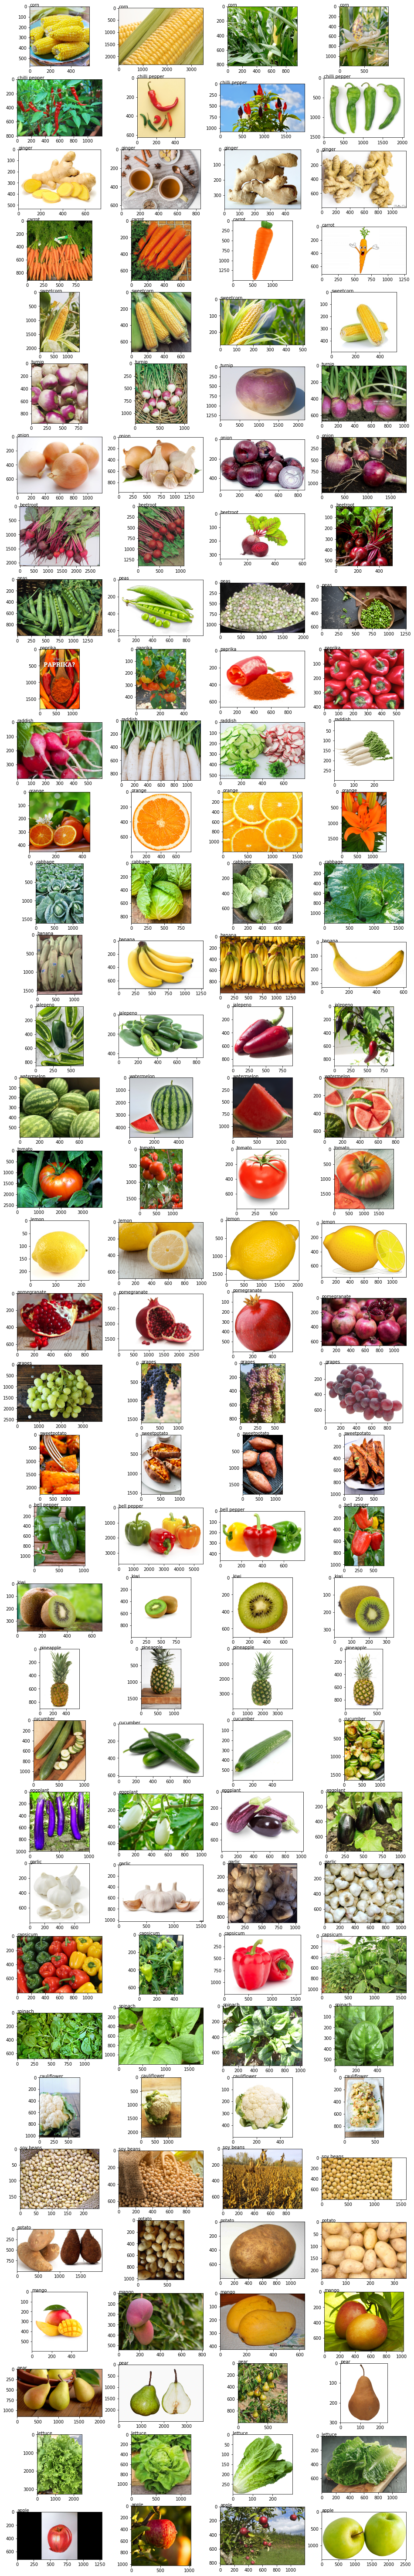

In [20]:
# Plot some training images from the dataset
nrows = len(CLASS_LABELS)
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(training_class_dir + '/' + training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [21]:
datagen_kwargs = dict(rescale=1./255)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=45,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=VALID_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 3115 images belonging to 36 classes.
Number of training image batches per epoch of modeling: 195
Loading and pre-processing the validation images...
Found 351 images belonging to 36 classes.
Number of validation image batches per epoch of modeling: 22


In [22]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [23]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [24]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [TRAIN_LOSS, TRAIN_METRIC]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == TRAIN_LOSS:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [25]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    classifier_activation=CLASSIFIER_ACTIVATION, loss_param=DEFAULT_LOSS,
                    opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu')),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [26]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(training_generator,
                                            epochs=MAX_EPOCHS,
                                            validation_data=validation_generator,
                                            verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/20
 10/195 [>.............................] - ETA: 1:36 - loss: 10.5626 - accuracy: 0.1125

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 29/195 [===>..........................] - ETA: 1:57 - loss: 6.6554 - accuracy: 0.2266

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


195/195 [==============================] - 198s 863ms/step - loss: 2.2225 - accuracy: 0.5740 - val_loss: 0.3958 - val_accuracy: 0.8575
Epoch 2/20
195/195 [==============================] - 164s 837ms/step - loss: 0.7817 - accuracy: 0.7811 - val_loss: 0.2519 - val_accuracy: 0.9031
Epoch 3/20
195/195 [==============================] - 164s 843ms/step - loss: 0.5651 - accuracy: 0.8189 - val_loss: 0.3535 - val_accuracy: 0.8889
Epoch 4/20
195/195 [==============================] - 164s 841ms/step - loss: 0.4525 - accuracy: 0.8517 - val_loss: 0.3373 - val_accuracy: 0.9031
Epoch 5/20
195/195 [==============================] - 163s 838ms/step - loss: 0.4007 - accuracy: 0.8738 - val_loss: 0.3472 - val_accuracy: 0.9088
Epoch 6/20
195/195 [==============================] - 163s 838ms/step - loss: 0.3512 - accuracy: 0.8822 - val_loss: 0.2713 - val_accuracy: 0.9345
Epoch 7/20
195/195 [==============================] - 163s 837ms/step - loss: 0.3276 - accuracy: 0.8947 - val_loss: 0.1907 - val_accura

In [27]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 2048)              192677888 
                                                                 
 dense_1 (Dense)             (None, 36)                73764     
                                                                 
Total params: 211,073,636
Trainable params: 210,844,580
Non-trainable params: 229,056
_________________________________________________________________


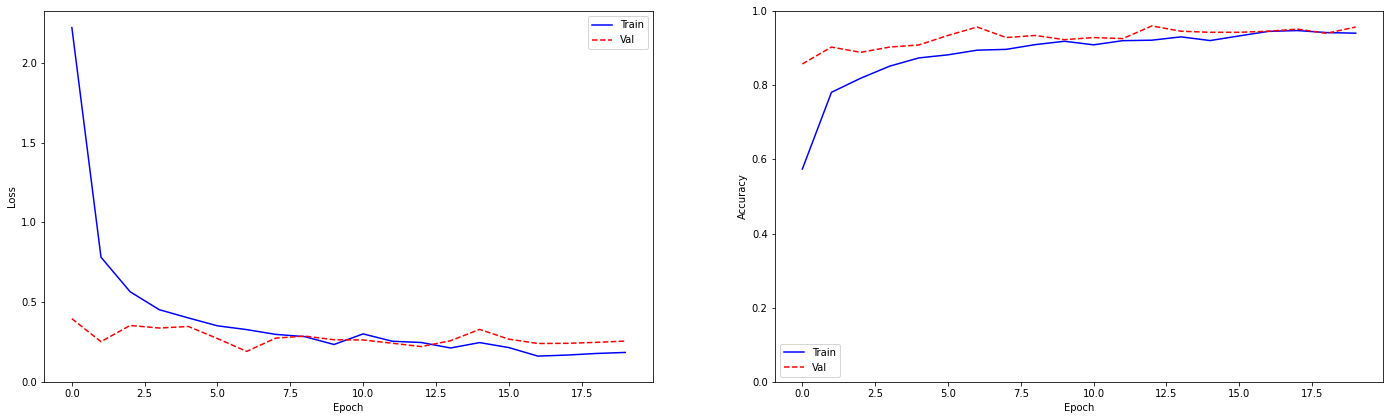

In [28]:
plot_metrics(baseline_model_history)

In [29]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Tune and Optimize Models

In [30]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [31]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
TUNING_LR = INITIAL_LR / 2
TUNE_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=TUNING_LR)
MINIMUM_LR = TUNING_LR / 4
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=MINIMUM_LR)
tf.keras.utils.set_random_seed(RNG_SEED)
tune_model = create_nn_model(opt_param=TUNE_OPTIMIZER)
tune_model_history = tune_model.fit(training_generator,
                                    epochs=MAX_EPOCHS,
                                    validation_data=validation_generator,
                                    callbacks=[learning_rate_reduction],
                                    verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/20
 36/195 [====>.........................] - ETA: 1:43 - loss: 3.7031 - accuracy: 0.2715

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


195/195 [==============================] - 186s 861ms/step - loss: 1.8223 - accuracy: 0.5689 - val_loss: 0.4824 - val_accuracy: 0.8519 - lr: 5.0000e-05
Epoch 2/20
195/195 [==============================] - 164s 843ms/step - loss: 0.7211 - accuracy: 0.7846 - val_loss: 0.2966 - val_accuracy: 0.9174 - lr: 5.0000e-05
Epoch 3/20
195/195 [==============================] - 164s 842ms/step - loss: 0.5340 - accuracy: 0.8417 - val_loss: 0.2036 - val_accuracy: 0.9316 - lr: 5.0000e-05
Epoch 4/20
195/195 [==============================] - 165s 844ms/step - loss: 0.4053 - accuracy: 0.8681 - val_loss: 0.1903 - val_accuracy: 0.9430 - lr: 5.0000e-05
Epoch 5/20
195/195 [==============================] - 164s 842ms/step - loss: 0.3500 - accuracy: 0.8831 - val_loss: 0.1811 - val_accuracy: 0.9430 - lr: 5.0000e-05
Epoch 6/20
195/195 [==============================] - 164s 839ms/step - loss: 0.2685 - accuracy: 0.9104 - val_loss: 0.1363 - val_accuracy: 0.9573 - lr: 5.0000e-05
Epoch 7/20
195/195 [=============

In [32]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [33]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [34]:
FINAL_LR = 0.0000125
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=FINAL_LR)
FINAL_EPOCHS = MAX_EPOCHS
tf.keras.utils.set_random_seed(RNG_SEED)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(training_generator, epochs=FINAL_EPOCHS, verbose=1)
final_model.summary()

Epoch 1/20
 19/195 [=>............................] - ETA: 2:18 - loss: 3.8150 - accuracy: 0.1204

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 87/195 [============>.................] - ETA: 1:22 - loss: 2.5101 - accuracy: 0.3655

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


195/195 [==============================] - 164s 747ms/step - loss: 1.8034 - accuracy: 0.5226
Epoch 2/20
195/195 [==============================] - 146s 751ms/step - loss: 0.7697 - accuracy: 0.7650
Epoch 3/20
195/195 [==============================] - 146s 748ms/step - loss: 0.5986 - accuracy: 0.8228
Epoch 4/20
195/195 [==============================] - 146s 748ms/step - loss: 0.4128 - accuracy: 0.8687
Epoch 5/20
195/195 [==============================] - 146s 748ms/step - loss: 0.3787 - accuracy: 0.8825
Epoch 6/20
195/195 [==============================] - 146s 748ms/step - loss: 0.3040 - accuracy: 0.9037
Epoch 7/20
195/195 [==============================] - 146s 749ms/step - loss: 0.2380 - accuracy: 0.9246
Epoch 8/20
195/195 [==============================] - 147s 752ms/step - loss: 0.2056 - accuracy: 0.9342
Epoch 9/20
195/195 [==============================] - 146s 749ms/step - loss: 0.1811 - accuracy: 0.9380
Epoch 10/20
195/195 [==============================] - 146s 750ms/step - lo

### 5.b) Load Test Dataset and Make Predictions

In [35]:
# Brief listing of test image files for each class
for c_label in CLASS_LABELS:
    test_class_dir = os.path.join(TEST_DIR, c_label)
    test_class_files = os.listdir(test_class_dir)
    print('Number of test images for', c_label, ':', len(os.listdir(test_class_dir)))
    print('Training samples for', c_label, ':')
    print(test_class_files[:5],'\n')

Number of test images for corn : 10
Training samples for corn :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.jpg', 'Image_2.jpg', 'Image_1.jpg'] 

Number of test images for chilli pepper : 10
Training samples for chilli pepper :
['Image_8.jpg', 'Image_6.jpeg', 'Image_2.png', 'Image_4.jpg', 'Image_5.png'] 

Number of test images for ginger : 10
Training samples for ginger :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.jpg', 'Image_2.jpg', 'Image_1.jpg'] 

Number of test images for carrot : 10
Training samples for carrot :
['Image_8.jpg', 'Image_9.jpeg', 'Image_6.jpg', 'Image_4.png', 'Image_2.jpg'] 

Number of test images for sweetcorn : 10
Training samples for sweetcorn :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.jpg', 'Image_2.jpg', 'Image_1.jpg'] 

Number of test images for turnip : 10
Training samples for turnip :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.jpg', 'Image_2.jpg', 'Image_1.jpg'] 

Number of test images for onion : 10
Training samples for onion :
['Image_8.jpg', 'Image_6.jpg', 'Image_4.

In [36]:
datagen_kwargs = dict(rescale=1./255)
test_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

print('Loading and pre-processing the test images...')
test_generator = validation_datagen.flow_from_directory(directory=TEST_DIR,
                                                        target_size=TARGET_IMAGE_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False,
                                                        **dataflow_kwargs)
print('Number of test image batches per epoch of modeling:', len(test_generator))

Loading and pre-processing the test images...
Found 359 images belonging to 36 classes.
Number of test image batches per epoch of modeling: 23


In [37]:
# Print the labels used for the modeling
print(test_generator.class_indices)

{'apple': 0, 'banana': 1, 'beetroot': 2, 'bell pepper': 3, 'cabbage': 4, 'capsicum': 5, 'carrot': 6, 'cauliflower': 7, 'chilli pepper': 8, 'corn': 9, 'cucumber': 10, 'eggplant': 11, 'garlic': 12, 'ginger': 13, 'grapes': 14, 'jalepeno': 15, 'kiwi': 16, 'lemon': 17, 'lettuce': 18, 'mango': 19, 'onion': 20, 'orange': 21, 'paprika': 22, 'pear': 23, 'peas': 24, 'pineapple': 25, 'pomegranate': 26, 'potato': 27, 'raddish': 28, 'soy beans': 29, 'spinach': 30, 'sweetcorn': 31, 'sweetpotato': 32, 'tomato': 33, 'turnip': 34, 'watermelon': 35}


In [38]:
final_model.evaluate(test_generator, verbose=1)

13/23 [===============>..............] - ETA: 8s - loss: 0.1223 - accuracy: 0.9615

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


23/23 [==============================] - 22s 833ms/step - loss: 0.1398 - accuracy: 0.9638


[0.13976038992404938, 0.9637883305549622]

In [39]:
test_pred = final_model.predict(test_generator)
test_predictions = np.argmax(test_pred, axis=-1)
test_original = test_generator.labels
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Accuracy Score: 0.9637883008356546
[[ 8  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00        10
           3       0.91      1.00      0.95        10
           4       1.00      1.00      1.00        10
           5       1.00      0.90      0.95        10
           6       1.00      0.90      0.95        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.89      0.80      0.84        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        1

In [40]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [41]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 2:41:21.841769
